In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/sebastian/masters/') # add my repo to python path
import os
import torch
import torch.nn.functional as F
import torch_geometric
import kmbio  # fork of biopython PDB with some changes in how the structure, chain, etc. classes are defined.
import numpy as np
import pandas as pd
import proteinsolver
import modules

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, BatchSampler
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import *
from torch import nn, optim
from pathlib import Path

from modules.dataset import *
from modules.utils import *
from modules.model import *
from modules.lstm_utils import *

np.random.seed(1)

### Paths

In [2]:
root = Path("/home/sebastian/masters/data/")
data_root = root / "neat_data"
metadata_path = data_root / "metadata.csv"
processed_dir = data_root / "processed" / "tcr_binding"
state_file = root / "state_files" / "e53-s1952148-d93703104.state"
out_dir = root / "state_files" / "tcr_binding"

### Get metadata

In [3]:
model_dir = data_root / "raw" / "tcrpmhc"

paths = list(model_dir.glob("*"))
join_key = [int(x.name.split("_")[0]) for x in paths]
path_df = pd.DataFrame({'#ID': join_key, 'path': paths})

metadata = pd.read_csv(metadata_path)
metadata = metadata.join(path_df.set_index("#ID"), on="#ID", how="inner")  # filter to non-missing data
metadata = metadata.reset_index(drop=True)
metadata

,#ID,CDR3a,CDR3b,peptide,partition,binder,v_gene_alpha,j_gene_alpha,v_gene_beta,j_gene_beta,origin,v_alpha_vdjdb_name,j_alpha_vdjdb_name,v_beta_vdjdb_name,j_beta_vdjdb_name,path
0,1,AVSQSNTGKLI,ASSQLMENTEAF,NLVPMVATV,1,0,TRAV12-2,TRAJ37,TRBV4-1,TRBJ1-1,tenX,TRAV12-2*01,TRAJ37*01,TRBV4-1*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
1,2,AASEVCADYKLS,ASSYSLLRAAPNTEAF,NLVPMVATV,1,0,TRAV29DV5,TRAJ20,TRBV6-3,TRBJ1-1,tenX,TRAV29/DV5*01,TRAJ20*01,TRBV6-3*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
2,3,AGRLGAQKLV,ASSQGGRRNQPQH,NLVPMVATV,1,0,TRAV25,TRAJ54,TRBV4-2,TRBJ1-5,tenX,TRAV25*01,TRAJ54*01,TRBV4-2*01,TRBJ1-5*01,/home/sebastian/masters/data/neat_data/raw/tcr...
3,4,AVEPLYGNKLV,ASSSREAEAF,NLVPMVATV,1,0,TRAV22,TRAJ47,TRBV7-9,TRBJ1-1,tenX,TRAV22*01,TRAJ47*01,TRBV7-9*01,TRBJ1-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
4,5,ASGTYKYI,ASSQRAGRVDTQY,NLVPMVATV,1,0,TRAV19,TRAJ40,TRBV27,TRBJ2-3,tenX,TRAV19*01,TRAJ40*01,TRBV27*01,TRBJ2-3*01,/home/sebastian/masters/data/neat_data/raw/tcr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10326,12961,AVNSYYNQGGKLI,SVLQGSPYEQY,GILGFVFTL,1,1,TRAV12-2*01,TRAJ23*01,TRBV29-1*01,TRBJ2-7*01,positive,TRAV12-2*01,TRAJ23*01,TRBV29-1*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...
10327,12962,AGNYGGSQGNLI,ASSIYSVNEQF,GILGFVFTL,1,1,TRAV35*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,positive,TRAV35*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,/home/sebastian/masters/data/neat_data/raw/tcr...
10328,12966,AVGGSQGNLI,ASSVRSSYEQY,GILGFVFTL,1,1,TRAV8-6*02,TRAJ42*01,TRBV19*01,TRBJ2-7*01,positive,TRAV8-6*01,TRAJ42*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...
10329,12968,AENGGGGADGLT,ASSIRSSYEQY,GILGFVFTL,1,1,TRAV13-2*01,TRAJ45*01,TRBV19*01,TRBJ2-7*01,positive,TRAV13-2*01,TRAJ45*01,TRBV19*01,TRBJ2-7*01,/home/sebastian/masters/data/neat_data/raw/tcr...


### Make GNN embeddings

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# init proteinsolver gnn
num_features = 20
adj_input_size = 2
hidden_size = 128

gnn = Net(
    x_input_size=num_features + 1, 
    adj_input_size=adj_input_size, 
    hidden_size=hidden_size, 
    output_size=num_features
)
gnn.load_state_dict(torch.load(state_file, map_location=device))
gnn.eval()
gnn = gnn.to(device)

raw_files = np.array(metadata["path"])
targets = np.array(metadata["binder"])

dataset = ProteinDataset(processed_dir, raw_files, targets, overwrite=False)

In [28]:
def create_gnn_embeddings(
    dataset, 
    out_dir, 
    device, 
    gnn_func, 
    cores=1, 
    overwrite=False, 
    chain_keys=np.array(["P", "M", "A", "B"])
):  
    def _sub_process(out_path, data, chain_keys, gnn_func):
            data = data.to("cpu")
            with torch.no_grad():
                    out = gnn_func(data.x, data.edge_index, data.edge_attr)
  
            # add positional encoding of chains
            positional_encoding = np.zeros((len(data.x), len(chain_keys)))
            for j, p in enumerate(data.chain_map[0]):
                positional_encoding[j][np.where(chain_keys == p)] = 1
            positional_encoding = torch.Tensor(positional_encoding)
            out = torch.cat((out, positional_encoding), dim=1)

            torch.save(out, out_path)

    out_dir.mkdir(mode=0o775, parents=True, exist_ok=True)
    
    data_loader = torch_geometric.loader.DataLoader(dataset, shuffle=False, batch_size=1)
    out_files = list()
    targets = list()
    for i, data in enumerate(data_loader):
        out_path = out_dir / f"data_{i}.pt"
        if not out_path.is_file() or overwrite:
            out_files.append(out_path)
        targets.append([data.y])
    torch.save(targets, out_dir / f"targets.pt")

    sub_process = lambda out_path, data: _sub_process(
        out_path,
        data,
        gnn_func=gnn_func,
        chain_keys=chain_keys,
    )
    Parallel(n_jobs=cores)(delayed(sub_process)(*arg) for arg in zip(out_files, data_loader))
        
        #out_path = out_dir / f"data_{i}.pt"
        #if not out_path.is_file() or overwrite:
        #    
        #    
        #    data = data.to("cpu")
        #    with torch.no_grad():
        #            out = gnn_func(data.x, data.edge_index, data.edge_attr)
  #
        #    # add positional encoding of chains
        #    positional_encoding = np.zeros((len(data.x), len(chain_keys)))
        #    for j, p in enumerate(data.chain_map[0]):
        #        positional_encoding[j][np.where(chain_keys == p)] = 1
        #    positional_encoding = torch.Tensor(positional_encoding)
        #    out = torch.cat((out, positional_encoding), dim=1)
#
        #    torch.save(out, out_path)
#
        #targets.append([data.y])
    #torch.save(targets, out_dir / f"targets.pt")

gnn_func = gnn.forward_without_last_layer
out_dir = processed_dir / "gnn_out_pos_128_test"
create_gnn_embeddings(dataset, out_dir, device, gnn_func, cores=4, overwrite=False)
#create_gnn_embeddings(dataset, out_dir, device, gnn_func, overwrite=False)

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

### Make LOO partitions and init dataset

In [7]:
unique_peptides = metadata["peptide"].unique()

metadata["merged_chains"] = metadata["CDR3a"] + metadata["CDR3b"]
loo_train_partitions = list()
loo_valid_partitions = list()
for pep in unique_peptides:
    valid_df = metadata[metadata["peptide"] == pep]
    valid_unique_cdr = valid_df["merged_chains"].unique()
    
    # get training rows and drop swapped data
    train_df = metadata[metadata["peptide"] != pep]
    train_df = train_df[~train_df["merged_chains"].str.contains('|'.join(valid_unique_cdr))]

    loo_train_partitions.append(list(train_df.index))
    loo_valid_partitions.append(list(valid_df.index))

dataset = LSTMDataset(
    data_dir=processed_dir / "gnn_out_pos_128", 
    annotations_path=processed_dir / "gnn_out_pos_128" / "targets.pt"
)

# hacky dataset fix
# hacky dataset fix
# hacky dataset fix
filtered_peptides = ["CLGGLLTMV", "ILKEPVHGV"]
filtered_indices = list()
filtered_partitions = list()

for pep in filtered_peptides:
    filtered_indices.extend(list(metadata[metadata["peptide"] == pep].index))
    filtered_partitions.extend(np.where(unique_peptides == pep)[0])

loo_train_partitions = [part for i, part in enumerate(loo_train_partitions) if i not in filtered_partitions]
loo_valid_partitions = [part for i, part in enumerate(loo_valid_partitions) if i not in filtered_partitions]

filtered_indices = set(filtered_indices)

for i in range(len(loo_train_partitions)):
    train_part, valid_part = loo_train_partitions[i], loo_valid_partitions[i]
    train_part = [i for i in train_part if i not in filtered_indices]
    valid_part = [i for i in valid_part if i not in filtered_indices]
    loo_train_partitions[i], loo_valid_partitions[i] = train_part, valid_part
    
unique_peptides = np.delete(unique_peptides, filtered_partitions)

In [8]:
for x in [(len(x), len(y), len(x)+len(y)) for x,y in zip(loo_train_partitions, loo_valid_partitions)]:
    print(x)

(8381, 1217, 9598)
(10214, 70, 10284)
(10174, 87, 10261)
(10017, 201, 10218)
(10253, 39, 10292)
(10236, 54, 10290)
(10182, 89, 10271)
(10169, 86, 10255)
(9946, 217, 10163)
(10262, 34, 10296)
(9917, 245, 10162)
(7613, 1667, 9280)
(10192, 76, 10268)
(2011, 6223, 8234)
(10306, 8, 10314)
(10308, 7, 10315)


### bi-LSTM

In [9]:
class MyLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, dropout=0.0):
        super(MyLSTM, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout, 
        )
        self.linear_dropout = nn.Dropout(p=dropout)
        self.linear_1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, 1)
        
        torch.nn.init.xavier_uniform_(self.linear_1.weight)
        torch.nn.init.xavier_uniform_(self.linear_2.weight)
    
    def forward(self, x):
        x, (h, c) = self.lstm(x)
        h_cat = torch.cat((h[-2,:,:], h[-1,:,:]), dim=1)
        out = self.linear_1(h_cat)
        out = self.linear_dropout(out)
        out = F.relu(out)
        out = self.linear_2(out)
        return out

# init LSTM
embedding_dim = 128 + 4 # add for for pos encoding

### Chain specific parallel LSTM

In [10]:
class QuadLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, dropout=0.0):
        super(QuadLSTM, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.dropout = dropout
        
        self.lstm_1 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
        )       
        self.lstm_2 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
        )        
        self.lstm_3 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout, 
            batch_first=True,
        )     
        self.lstm_4 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout, 
            batch_first=True,
        )
        
        self.linear_dropout = nn.Dropout(p=dropout)
        self.batch_norm = nn.BatchNorm1d(num_features=hidden_dim)
        self.linear_1 = nn.Linear(hidden_dim * 4, hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, 1)
        
        torch.nn.init.xavier_uniform_(self.linear_1.weight)
        torch.nn.init.xavier_uniform_(self.linear_2.weight)
    
    def forward(self, x_1, x_2, x_3, x_4):
        _, (h_1, _) = self.lstm_1(x_1)
        _, (h_2, _) = self.lstm_2(x_2)
        _, (h_3, _) = self.lstm_3(x_3)
        _, (h_4, _) = self.lstm_4(x_4)
        h_cat = torch.cat((h_1[-1], h_2[-1], h_3[-1], h_4[-1]), dim=1)
        out = self.linear_1(h_cat)
        out = self.batch_norm(out)
        out = F.relu(out)
        out = self.linear_dropout(out)
        out = self.linear_2(out)
        return out

### Parallel LSTM utils

In [11]:
#def pad_collate_chain_split(batch, pad_val=0):
#    (xx, yy) = zip(*batch)
#    x_1_batch = list()
#    x_2_batch = list()
#    x_3_batch = list()
#    x_4_batch = list()
#    for x in xx:
#        x_1_batch.append(x[x[:,-1] == 1][:,:-4])  # slice based on positional encoding and remove encoding part
#        x_2_batch.append(x[x[:,-2] == 1][:,:-4])
#        x_3_batch.append(x[x[:,-3] == 1][:,:-4])
#        x_4_batch.append(x[x[:,-4] == 1][:,:-4])
#
#    x1_pad = nn.utils.rnn.pad_sequence(x_1_batch, batch_first=True, padding_value=pad_val)
#    x2_pad = nn.utils.rnn.pad_sequence(x_2_batch, batch_first=True, padding_value=pad_val)
#    x3_pad = nn.utils.rnn.pad_sequence(x_3_batch, batch_first=True, padding_value=pad_val)
#    x4_pad = nn.utils.rnn.pad_sequence(x_4_batch, batch_first=True, padding_value=pad_val)
#    yy_pad = nn.utils.rnn.pad_sequence(yy, batch_first=True, padding_value=pad_val)
#    return (x1_pad, x2_pad, x3_pad, x4_pad), yy_pad


def pad_collate_chain_split(batch, pad_val=0, n_split=4):
    (xx, yy) = zip(*batch)
    x_split_batch = [list() for _ in range(n_split)]
    for x in xx:
        for i in range(n_split):
            x_split_batch[i].append(x[x[:,-i - 1] == 1][:,:-n_split])  # slice based on positional encoding and remove encoding part

    for i in range(n_split):
        x_split_batch[i] = nn.utils.rnn.pad_sequence(
            x_split_batch[i], 
            batch_first=True, 
            padding_value=pad_val
        )
    yy_pad = nn.utils.rnn.pad_sequence(yy, batch_first=True, padding_value=pad_val)
    return x_split_batch, yy_pad


def lstm_quad_train(
    model,
    epochs,
    criterion,
    optimizer,
    scheduler,
    dataset,
    train_idx,
    valid_idx,
    batch_size,
    device,
    extra_print=None,
):
    train_losses = list()
    valid_losses = list()
    
    for e in range(epochs):
        
        train_sampler = BatchSampler(SubsetRandomSampler(train_idx), batch_size=batch_size, drop_last=False)
        valid_sampler = BatchSampler(SubsetRandomSampler(valid_idx), batch_size=batch_size, drop_last=False)
        
        train_loader = DataLoader(dataset=dataset, batch_sampler=train_sampler, collate_fn=pad_collate_chain_split)
        valid_loader = DataLoader(dataset=dataset, batch_sampler=valid_sampler, collate_fn=pad_collate_chain_split)

        train_len = len(train_loader)
        valid_len = len(valid_loader)
        
        #if e > 5:
        #    net.linear_dropout.dropout = 0.6
        #    net.lstm_1.dropout = 0.6
        #    net.lstm_2.dropout = 0.6
        #    net.lstm_3.dropout = 0.6
        #    net.lstm_4.dropout = 0.6
            
        
        train_loss = 0
        model.train()
        j = 0
        for xx, y in train_loader:    
            y = y.to(device)
            xx = (x.to(device) for x in xx)
            y_pred = model(*xx)
            optimizer.zero_grad()
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            display_func(j, train_len, e, train_losses, valid_losses, extra_print)
            j += 1
        
        valid_loss = 0
        model.eval()
        with torch.no_grad():
            for xx, y in valid_loader:    
                y = y.to(device)
                xx = (x.to(device) for x in xx)
                y_pred = model(*xx)
                loss = criterion(y_pred, y)
                valid_loss += loss.item()
        
        scheduler.step()
        train_losses.append(train_loss / train_len)
        valid_losses.append(valid_loss / valid_len)

    return model, train_losses, valid_losses


def lstm_quad_predict(model, dataset, idx, device):
    data_loader = DataLoader(dataset=dataset, sampler=idx, batch_size=1, collate_fn=pad_collate_chain_split)
    pred = list()
    true = list()
    with torch.no_grad():
        for xx, y in data_loader:    
            xx = (x.to(device) for x in xx)
            y_pred = model(*xx)
            pred.append(torch.sigmoid(y_pred))
            true.append(y)
    return torch.Tensor(pred), torch.Tensor(true)

In [12]:
#indices = np.array(metadata.index)
#n_data = len(indices)
#valid_frac = 0.2
#valid_num = int(n_data * valid_frac)
#selection = np.random.randint(0, n_data, valid_num)
#mask = np.zeros(n_data, bool)
#mask[selection] = 1
#
#loo_valid_partitions = [indices[mask]]
#loo_train_partitions = [indices[~mask]]

### LOO training scheme

In [13]:
# LSTM params
batch_size = 64
embedding_dim = 128
hidden_dim = 64 #32
num_layers = 2  # from 2
epochs = 10
learning_rate = 1e-3
lr_decay = 0.95 #TODO set some val, 1=no effect
w_decay = 1e-4
dropout = 0.8  # test scheduled dropout. Can set droput using net.layer.dropout = 0.x https://arxiv.org/pdf/1703.06229.pdf

# touch files to ensure output
n_splits = len(unique_peptides)
save_dir = get_non_dupe_dir(out_dir)
loss_paths = touch_output_files(save_dir, "loss", n_splits)
state_paths = touch_output_files(save_dir, "state", n_splits)
pred_paths = touch_output_files(save_dir, "pred", n_splits)

extra_print_str = "\nSaving to {}\nFold: {}\nPeptide: {}"

i = 0
for train_idx, valid_idx in zip(loo_train_partitions, loo_valid_partitions):
    
    net = QuadLSTM(
        embedding_dim=embedding_dim, 
        hidden_dim=hidden_dim, 
        num_layers=num_layers, 
        dropout=dropout,
    )
    net = net.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(
        net.parameters(), 
        lr=learning_rate, 
        #weight_decay=w_decay,
    )  # test learning rate scheduler to reduce validation volatility
    scheduler = optim.lr_scheduler.MultiplicativeLR(
        optimizer, 
        lr_lambda=lambda epoch: lr_decay
    )
    
    net, train_losses, valid_losses = lstm_quad_train(
        net,
        epochs,
        criterion,
        optimizer,
        scheduler,
        dataset,
        train_idx,
        valid_idx,
        batch_size,
        device,
        extra_print_str.format(save_dir, i, unique_peptides[i]),
    )
    torch.save(net.state_dict(), state_paths[i])
    torch.save({"train": train_losses, "valid": valid_losses}, loss_paths[i])
    
    pred, true = lstm_quad_predict(net, dataset, valid_idx, device)     
    torch.save({"y_pred": pred, "y_true": true}, pred_paths[i])
    
    i += 1


Saving to /home/sebastian/masters/data/state_files/tcr_binding/7280513d3ac56bae689631e9c83f70f4
Fold: 1
Peptide: SLFNTVATL

epoch: 1 - n: 5/160 - [3%                                                           ]


KeyboardInterrupt: 

In [84]:
train_sampler = BatchSampler(SubsetRandomSampler(train_idx), batch_size=batch_size, drop_last=False)
valid_sampler = BatchSampler(SubsetRandomSampler(valid_idx), batch_size=batch_size, drop_last=False)

train_loader = DataLoader(dataset=dataset, batch_sampler=train_sampler, collate_fn=pad_collate_chain_split)
valid_loader = DataLoader(dataset=dataset, batch_sampler=valid_sampler, collate_fn=pad_collate_chain_split)

In [80]:
for train_idx, valid_idx in zip(loo_train_partitions, loo_valid_partitions):

    train_sampler = BatchSampler(SubsetRandomSampler(train_idx), batch_size=batch_size, drop_last=False)
    valid_sampler = BatchSampler(SubsetRandomSampler(valid_idx), batch_size=batch_size, drop_last=False)
    
    train_flat = [item for sublist in train_sampler for item in sublist]
    train_flat_set = set(train_flat)
    assert len(train_flat_set) == len(train_flat)

    valid_flat = [item for sublist in valid_sampler for item in sublist]
    valid_flat_set = set(valid_flat)
    assert len(valid_flat_set) == len(valid_flat)

    for x in train_flat:
        if x in valid_flat_set:
            print(x)

    train_flat.sort()
    valid_flat.sort()

    train_loader = DataLoader(dataset=dataset, sampler=train_flat, collate_fn=pad_collate)
    valid_loader = DataLoader(dataset=dataset, sampler=valid_flat, collate_fn=pad_collate)

    for x, i_t in zip(train_loader, train_idx):
        if not torch.all(torch.eq(torch.load(processed_dir / "gnn_out_pos_128" / f"data_{i_t}.pt"), x[0][0])):
            print(i_t)


    for x, i_t in zip(valid_loader, valid_idx):
        if not torch.all(torch.eq(torch.load(processed_dir / "gnn_out_pos_128" / f"data_{i_t}.pt"), x[0][0])):
            print(i_t)

Changes overview:
- dropout engage after x epochs
- batch norm between linear layers
- slight change in collate_fn
- LR scheduler
- LR dropped to 0.00001 (probably too small)
- added weight decay

### Performance metrics

0.5658824120855642 0.1830207910135854


KeyError: 'SLFNTVATL'

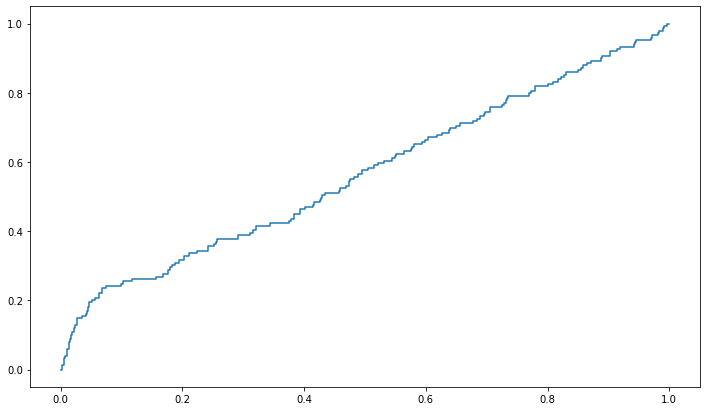

In [15]:
import matplotlib.pyplot as plt
import copy

n_splits = len(unique_peptides)
threshold = 0.2

# compute metrics
perf_data = dict()
for i in range(n_splits):
    data = torch.load(pred_paths[i])
    pred = data["y_pred"]
    true = data["y_true"]

    # auc
    auc = roc_auc_score(true, pred)
    fpr, tpr, thr = roc_curve(true, pred, pos_label=1)
    
    thresh_pred = torch.zeros(len(pred))
    thresh_pred[pred >= threshold] = 1
    mcc = matthews_corrcoef(true, thresh_pred)
    
    pep = unique_peptides[i]
    perf_data[pep] = [fpr, tpr, auc, mcc]

    print(auc, mcc)

performance_file = save_dir / "performance_data.pt"
torch.save(perf_data, performance_file)

# ROC plot
cm = plt.get_cmap('tab20')  # https://matplotlib.org/stable/tutorials/colors/colormaps.html

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1*i/n_splits) for i in range(n_splits)])
excluded = ["KLQCVDLHV", "KVAELVHFL", "YLLEMLWRL", "SLLMWITQV"] # TODO delete (filter <40 in test set)
for pep in unique_peptides:
    if pep not in excluded:
        ax.plot(
            perf_data[pep][0], 
            perf_data[pep][1], 
            label=f"{pep}, AUC = {round(perf_data[pep][2], 3)}",
        )
plt.legend()
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LOO validation ROC curve (peptides with count < 40 left out for visual clarity)")
plt.show()

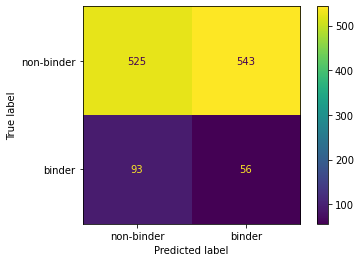

In [278]:
# confusion matrix
labels = ["non-binder", "binder"]
pred_copy = copy.deepcopy(pred)
pred_copy[pred >= 0.2] = 1
pred_copy[pred < 0.2] = 0
cm = confusion_matrix(true, pred_copy)

# f1
f1 = f1_score(true, pred_copy)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
plot = disp.plot()
plot.figure_.show()

In [ ]:
fold_idx = 1
data = torch.load(performance_file)[fold_idx]

cm, f1, auc = data["cm"], data["f1"], data["auc"]
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
print(f"LOO performance of fold {fold_idx}:")
print(f"AUC={auc}")
print(f"F1={f1}")

In [12]:
# quick viz
count_dict = dict()
for pep in unique_peptides:
    total = len(metadata[metadata["peptide"] == pep])
    pos = len(metadata[(metadata["peptide"] == pep) & (metadata["binder"] == 1)])
    count_dict[pep] = [total, pos]

In [13]:
count_dict

{'NLVPMVATV': [1217, 149],
 'SLFNTVATL': [70, 5],
 'KTWGQYWQV': [87, 11],
 'RTLNAWVKV': [201, 17],
 'KVLEYVIKV': [39, 6],
 'YLLEMLWRL': [54, 3],
 'IMDQVPFSV': [89, 8],
 'MLDLQPETT': [86, 11],
 'FLYALALLL': [217, 35],
 'SLLMWITQV': [34, 5],
 'LLFGYPVYV': [245, 30],
 'GLCTLVAML': [1667, 208],
 'RMFPNAPYL': [76, 9],
 'GILGFVFTL': [6223, 1311],
 'KLQCVDLHV': [8, 1],
 'KVAELVHFL': [7, 1]}

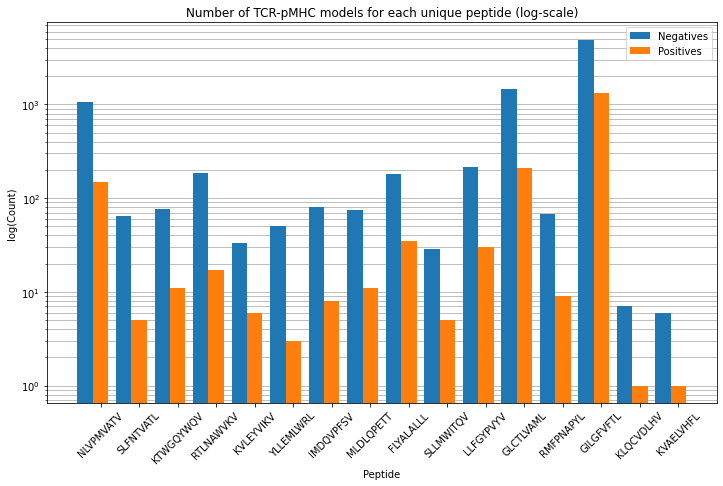

In [66]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

peptides = list(count_dict.keys())
negatives = [x[0] - x[1] for x in count_dict.values()]
positives = [x[1] for x in count_dict.values()]

width = 0.4
idx = np.arange(len(unique_peptides))

ax.bar(idx, negatives, width, zorder=3)
ax.bar(idx + width, positives, width, zorder=3)
ax.set_yscale('log')
ax.set_xticks(idx+width)
ax.set_xticklabels(count_dict.keys(), rotation=45)

ax.grid(zorder=0, which='both', axis='y')

plt.legend(["Negatives", "Positives"])
plt.xlabel("Peptide")
plt.ylabel("log(Count)")
plt.title("Number of TCR-pMHC models for each unique peptide (log-scale)")
plt.show()